# Classification:  Logistic Regression

In this lab, we will explore a commonly-used classification method named logistic regression. 

In [1]:
import scipy.special as spec
import scipy.stats as stats
%matplotlib inline
import numpy as np
from numpy import array as arr
import seaborn as sns
import matplotlib.pyplot as plt

First things first, please make sure you run ```ipython notebook``` in the ```day2/long/``` folder.

Now copy ```mushrooms.data``` and ```mushrooms.txt``` to the ```data``` subfolder of ```day2/long/```.

In [2]:
#this command should work without error:
import pandas as pd
data_path = 'data/mushrooms.data'
mushrooms = pd.read_csv(data_path)

Now let's define some toy data from the grade point average example from the talks (real data later).

In [3]:
xs = arr([3.26, 3.10, 3.42, 3.51, 3.62, 4.00])
N = len(xs)
X = np.vstack((np.ones((1,N)), xs)).T
Y = arr([0,0,1,0,1,1])
print('X',X)
print('Y',Y)

X [[ 1.    3.26]
 [ 1.    3.1 ]
 [ 1.    3.42]
 [ 1.    3.51]
 [ 1.    3.62]
 [ 1.    4.  ]]
Y [0 0 1 0 1 1]


We can next plot the data:

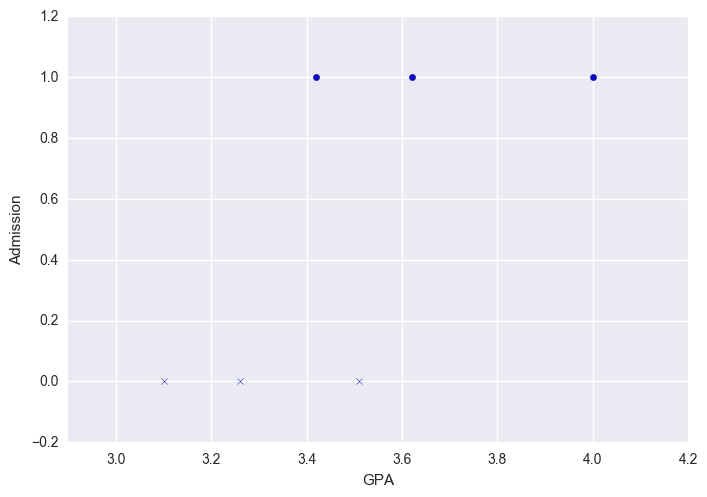

In [4]:
pos_ns = np.where(Y>0.5)
neg_ns = np.where(Y<=0.5)
plt.scatter(X[pos_ns,1],np.ones_like(pos_ns),marker='o')
plt.scatter(X[neg_ns,1],np.zeros_like(neg_ns),marker='x')
plt.xlim(xs.min()-0.2, xs.max()+0.2)
plt.xlabel('GPA')
plt.ylabel('Admission')

### Likelihood function
The log likelihood function of logistic regression is as follows:

$\mathcal{L}(\beta) = \sum_{n=1}^N \log \mathcal{B}(Y_n | g^{-1}({\bf X},{\bf \beta}))$

where $g^{-1}$ is the inverse link function $g^{-1}({\bf X},{\bf \beta}) = \sigma({\bf X}^\top {\bf \beta})$
and $\sigma$ is the softmax function $\sigma(t) = \frac{1}{1 + e^{-t}}$.

If we maximize $\mathcal{L}(\beta)$ with respect to $\beta$, then we have found the maximum likelihood solution that explains the data $({\bf X},{\bf Y})$. This allows one to make predictions for unseen $X$ and $Y$.

In [5]:
#define the inverse link function g^-1(eta)
def invg(X_,beta_):
    return spec.expit(np.dot(X_,beta_))

#define the negative log likelihood:
def neg_ll(beta_,X_,Y_): 
    mu = invg(X_,beta_)
    return -stats.bernoulli.logpmf(Y_, mu).sum()

## Gradient descent for Logistic Regression
Gradient descent is a useful tool to maximize objective functions (more on that in this afternoon's session). To do that, we need to create a Python function that will give the derivative $\frac{\mathrm{d}}{\mathrm{d} \beta}\mathcal{L}(\beta)$.

In [6]:
#first derivative of negative log likelihood function for logistic regression:
def deriv_neg_ll(beta_,X_,Y_):
    (N_,_) = X_.shape
    mu = invg(X_,beta_)
    return -arr([X_[i]*(Y_[i] - mu[i]) for i in range(N_)]).sum(axis=0)

#### (Bonus Task)
If you feel comfortable: try and derive the derivative (implemented above) for logistic regression:
$\frac{\mathrm{d}}{\mathrm{d} \beta}\mathcal{L}(\beta) = \sum_{n=1}^N X_n (Y_n - \sigma({\bf X_n}^\top {\bf \beta}))$

### Optimization
To perform gradient descent, we use the ```scipy.optimize``` package and call the ```fmin_bfgs``` function, giving it:

1. the objective function;
2. an initial guess of $\beta$; and
3. the derivative of the objective function. 
    
```fmin_bfgs``` will find the minimum for us.

In [7]:
import scipy.optimize as opt
beta0 = arr([-1.,1.]) #initial guess of coefficients
beta_opt = opt.fmin_bfgs(lambda beta_: neg_ll(beta_,X,Y), beta0, fprime=lambda beta_: deriv_neg_ll(beta_,X,Y))

Optimization terminated successfully.
         Current function value: 2.227095
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18


### Task
Print to the terminal 4 things:

1. $\beta_\mathrm{opt}$;
2. the log likelihood $\mathcal{L}(\beta_0)$ of the original guess for $\beta$ that we used;
3. the log likelihood $\mathcal{L}(\beta_\mathrm{opt})$of the optimal $\beta$ that was found; and
4. the predictions that logistic regression makes for all the observed $X_{1:N}$ defined in code earlier.

In [8]:
print('init_ll',-neg_ll(beta0,X,Y))
print('beta_opt',beta_opt)
print('max_ll',-neg_ll(beta_opt,X,Y))
print('pred_x',invg(X,beta_opt)) #np.expit(np.dot(X,beta_opt))

init_ll -7.36696147436
xopt [-36.70274019  10.60953098]
max_ll -2.22709467118
pred_x [ 0.10758316  0.02160066  0.3969609   0.63104758  0.84602543  0.99678075]


### Plotting
I will now plot the figure shown in the slides. Positive examples use the ```o``` marker, negative examples use the ```x``` marker and the probability of admission $p(Y_n = 1 | \mu_{x})$ is the blue curve.

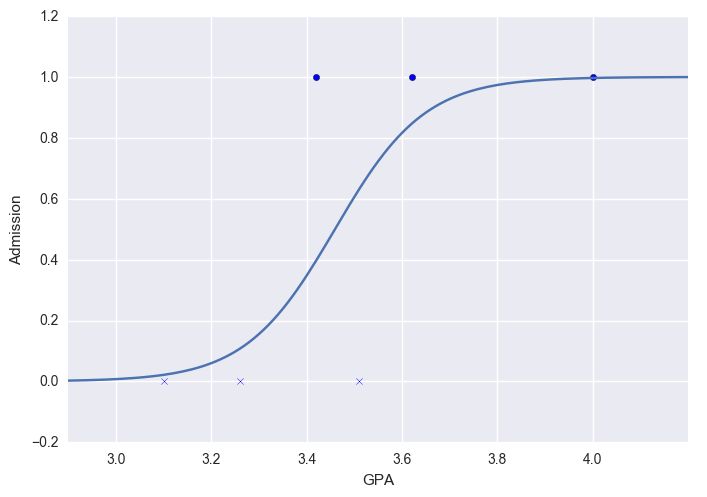

In [9]:
xs1 = np.arange(xs.min()-0.2, xs.max()+0.2, 0.01)
X1 = np.vstack((np.ones((1,len(xs1))),xs1)).T
ys1 = invg(X1,beta_opt)

plt.scatter(X[pos_ns,1],np.ones_like(pos_ns),marker='o')
plt.scatter(X[neg_ns,1],np.zeros_like(neg_ns),marker='x')
plt.plot(xs1, ys1)
plt.xlim(xs1.min(), xs1.max())
plt.xlabel('GPA')
plt.ylabel('Admission')

## Classifying Mushrooms
Let's use a data set, provided by the University of California, Irvine (UCI). It consists of features of approximately 8,000 mushrooms and whether each mushroom was poisonous (```p```) or edible (```e```). 

We treat the prediction of whether a mushroom is edible (1) or poisonous (0) as a logistic regression. The independent variables will be the 22 features, all of which are *categorical*. 

In [17]:
mushrooms['f11'] #browse data in a table format

0       e
1       c
2       c
3       e
4       e
5       c
6       c
7       c
8       e
9       c
10      c
11      c
12      c
13      e
14      e
15      e
16      e
17      e
18      e
19      e
20      c
21      e
22      c
23      c
24      c
25      e
26      c
27      c
28      e
29      b
       ..
8094    ?
8095    c
8096    ?
8097    ?
8098    ?
8099    ?
8100    ?
8101    ?
8102    ?
8103    ?
8104    ?
8105    ?
8106    ?
8107    ?
8108    ?
8109    ?
8110    ?
8111    ?
8112    ?
8113    ?
8114    c
8115    ?
8116    ?
8117    ?
8118    ?
8119    ?
8120    ?
8121    ?
8122    ?
8123    ?
Name: f11, dtype: object

In [11]:
mushrooms.describe()

,edibility,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


### Task: Reading the feature descriptors
Take a few minutes to read the file ```mushrooms.txt``` (provided in the ```data/``` subfolder) to find out what the 22 features mean as best you can.

### Question: 
What is the class occurrence of this data set, i.e., what percentage of the mushrooms are poisonous vs. edible?
### Answer:
[here]

### Processing the data
In its current state, the ```pandas``` dataframe ```mushrooms``` cannot be used with logistic regression because there are letters in the table instead of numbers. Pandas provides a convenient function, ```get_dummies``` to convert this table into a table of *one-hot* vectors.

A *one-hot* vector represents a discrete feature $x_f$ that could take 1 of $V$ distinct values ($x_f = s_1 \mathrm{\;or\;} s_2 \mathrm{\;or\;} \dots \mathrm{\;or\;} s_V \}$ as a vector of size $V$ consisting of all zeros except for one location $v$.

In [12]:
feature_cols = ['f%i'%j for j in range(1,23)]
mcat = pd.get_dummies(mushrooms, columns=['edibility']+feature_cols)
mcat

,edibility_e,edibility_p,f1_b,f1_c,f1_f,f1_k,f1_s,f1_x,f2_f,f2_g,...,f21_s,f21_v,f21_y,f22_d,f22_g,f22_l,f22_m,f22_p,f22_u,f22_w
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [23]:
#function to extract np.array's from dataframe and add intercept column:
def one_hot(df):
    X_, Y_ = df.iloc[:,1:].values, df.iloc[:,0].values
    (N_,D_) = X_.shape
    #add intercept column:
    c = np.ones((N_,1))
    return np.hstack((c,X_)), Y_

Split the data into training and testing data. [Covered more in evaluation session]:

In [24]:
#split the data into training and testing 50%-50%
np.random.seed(0)
train_mask = np.random.rand(len(mcat)) < 0.50
mcat_train = mcat[train_mask]
mcat_test = mcat[~train_mask]

#mushroom data set is too easy: let's randomly flip some dependent variables to make it harder
#(please ignore):
def corrupt(Y_,p=0.3):
    flips = np.random.binomial(1,p,size=len(Y_)) #please ignore
    return (1-flips)*Y_ + flips*(1-Y_) #please ignore

#convert training data to one-hot representation:
X, Y_easy = one_hot(mcat_train)
Y = corrupt(Y_easy)

#convert testing data to one-hot representation:
Xtest, Ytest_easy = one_hot(mcat_test)
Ytest = corrupt(Ytest_easy)

print('X',X)
print('Y',Y)
print('Xtest',Xtest)
print('Ytest',Ytest)

X [[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  1. ...,  0.  0.  0.]
 [ 1.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  1.  0. ...,  0.  0.  0.]]
Y [ 1.  0.  1. ...,  1.  1.  0.]
Xtest [[ 1.  1.  0. ...,  0.  1.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 1.  1.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]]
Ytest [ 0.  1.  0. ...,  0.  1.  1.]


### Running logistic regression on mushrooms
Below we finally apply logistic regression to the mushroom data:

In [25]:
np.random.seed(1)
(N,D) = X.shape
beta0 = np.random.normal(0,1,size=(D,)) #initial guess of coefficients
print('init_ll',-neg_ll(beta0,X,Y))
beta_opt = opt.fmin_bfgs(lambda beta_: neg_ll(beta_,X,Y), beta0, fprime=lambda beta_: deriv_neg_ll(beta_,X,Y))
print('max_ll',-neg_ll(beta_opt,X,Y))
print('pred_E_Y',spec.expit(np.dot(X,beta_opt)))

init_ll -5415.38873106
Optimization terminated successfully.
         Current function value: 2482.399073
         Iterations: 110
         Function evaluations: 116
         Gradient evaluations: 116
max_ll -2482.39907342
pred_E_Y [ 0.69544237  0.70760428  0.64522253 ...,  0.54849446  0.61734574
  0.3096518 ]


## Task
Calculate the held-out accuracy of logistic regression on the mushroom data set. What are the most influential features for identifying poisonous mushrooms? What are the least influential? (Hint: use the bar chart then cross-reference with ```mushrooms.txt``` help file, and don't forget about the fact that the first coefficient is the intercept value.)

Ybinpred [ 1.  1.  1. ...,  0.  1.  0.]
RMSE, accuracy on train (beta_init) 0.60692829287 0.524478914203
Ybinpred [ 1.  1.  1. ...,  1.  1.  0.]
RMSE, accuracy on train (beta_opt) 0.454097129083 0.7018904508
Ybinpred [ 0.  1.  1. ...,  0.  1.  0.]
RMSE, accuracy on test (beta_opt) 0.457314597503 0.706353176588


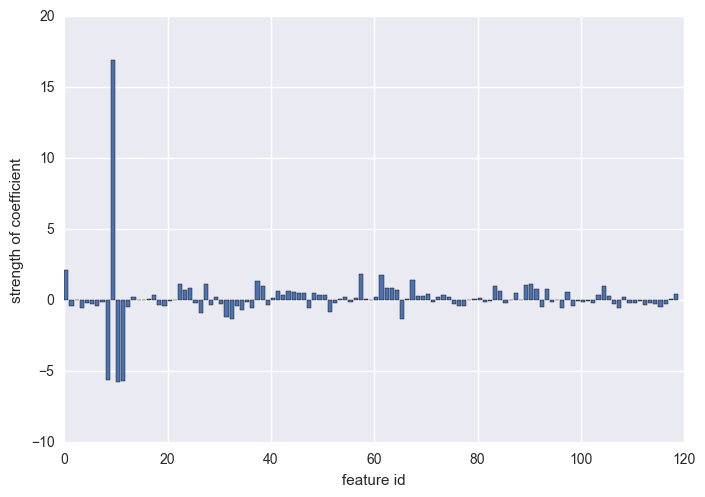

In [26]:
def rmse(X_,Y_,beta_):
    Ypred = invg(X_,beta_)
    mse = ((Y_ - Ypred)**2).mean()
    return np.sqrt(mse)

def accuracy(X_,Y_,beta_):
    Ypred = invg(X_,beta_)
    Ybinpred = np.around(Ypred)
    print('Ybinpred',Ybinpred)
    err = np.abs(Y_ - Ybinpred).mean()
    return 1.-err

print('RMSE, accuracy on train (beta_init)',rmse(X,Y,beta0), accuracy(X,Y,beta0))
print('RMSE, accuracy on train (beta_opt)',rmse(X,Y,beta_opt), accuracy(X,Y,beta_opt))
print('RMSE, accuracy on test (beta_opt)',rmse(Xtest,Ytest,beta_opt), accuracy(Xtest,Ytest,beta_opt))

#plot the trained coefficients:
plt.bar(range(D), beta_opt)
plt.xlabel('feature id')
plt.ylabel('strength of coefficient')

In [ ]:
#This is the end of the lab. Note that there was a mistake in the function "one_hot":
#pandas.get_dummies() will produce two first columns for the Y value (we only need one, since 
#it was originally a binary value), which means that X starts in column 3 not 2.
#The accuracy is very similar whether you take from column 3 onwards vs. column 2, 
#but here is the correct version for completeness. (Also, the function name "one_hot"
#could have been improved to something more descriptive.)
def one_hot_modified(df):
    X_, Y_ = df.iloc[:,2:].values, df.iloc[:,0].values
    (N_,D_) = X_.shape
    #add intercept column:
    c = np.ones((N_,1))
    return np.hstack((c,X_)), Y_